# 02. Model Training (Standard CNN)

This notebook covers:
1. Loading the real dataset (with mapping).
2. Defining a ResNet50-based Transfer Learning model.
3. Training the model (CrossEntropyLoss, Adam).
4. Evaluating performance (Accuracy, Loss).
5. Saving the model.
6. Detailed Evaluation (Classification Report, Confusion Matrix, ROC Curves).

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Config
DATA_ROOT = '../Data'
CLASSES = ['hemorrhagic', 'ischemic', 'tumor']
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Define paths to source data for each class
DATA_SOURCES = {
    'hemorrhagic': [
        os.path.join(DATA_ROOT, 'Brain_Stroke_CT_Dataset', 'Bleeding', 'PNG')
    ],
    'ischemic': [
        os.path.join(DATA_ROOT, 'Brain_Stroke_CT_Dataset', 'Ischemia', 'PNG')
    ],
    'tumor': [
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'glioma'),
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'meningioma'),
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'pituitary')
    ]
}

## 1. Data Loading
Using the same BrainDataset logic as preprocessing.

In [ ]:
class BrainDataset(Dataset):
    def __init__(self, data_sources, classes, transform=None):
        self.data_sources = data_sources
        self.classes = classes
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self._prepare_data()
        
    def _prepare_data(self):
        for label_idx, class_name in enumerate(self.classes):
            if class_name not in self.data_sources:
                continue 
            sources = self.data_sources[class_name]
            for source_dir in sources:
                if not os.path.exists(source_dir):
                    continue
                valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif')
                files = [f for f in os.listdir(source_dir) if f.lower().endswith(valid_exts)]
                for fname in files:
                    self.image_paths.append(os.path.join(source_dir, fname))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
        except:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
        if self.transform:
            img = self.transform(img)
        return img, label

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = BrainDataset(DATA_SOURCES, CLASSES, transform=train_transforms)

# Debug: Print class distribution
from collections import Counter
label_counts = Counter(full_dataset.labels)
print("Loaded data distribution:")
for i, class_name in enumerate(CLASSES):
    print(f"  {class_name}: {label_counts[i]} images")

# Split into train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# Override val transform (hacky but works since dataset references same object, better to use subset with transform but for simplicity:)
# Actually random_split returns Subset. We can't easily change transform of Subset.dataset without affecting train.
# For this simple project, using train_transforms (augmentation) for val is acceptable, or we re-instantiate.
# Let's just use train_transforms for both for simplicity as per original code.

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
}


## 2. Model Definition
Using ResNet50 pretrained on ImageNet.

In [ ]:
def get_model(num_classes):
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

model = get_model(len(CLASSES))
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## 3. Training Loop

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # Ensure float conversion for MPS compatibility
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                os.makedirs('../models', exist_ok=True)
                torch.save(model.state_dict(), '../models/best_cnn.pth')
                print(f'Saved best model with acc: {best_acc:.4f}')
                
    return history

# Start training
history = train_model(model, criterion, optimizer, num_epochs=EPOCHS)

## 4. Plot Results

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

## 5. Detailed Evaluation
Classification Report, Confusion Matrix, and ROC Curves.

/Users/hamzaelghonemy/Desktop/University/Senior/Neuroengineering/FinalProject/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hamzaelghonemy/Desktop/University/Senior/Neuroengineering/FinalProject/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating Best Model on Validation Set...
Classification Report:
              precision    recall  f1-score   support

 hemorrhagic       1.00      0.95      0.97       227
    ischemic       0.94      1.00      0.97       219
       tumor       1.00      1.00      1.00       822

    accuracy                           0.99      1268
   macro avg       0.98      0.98      0.98      1268
weighted avg       0.99      0.99      0.99      1268



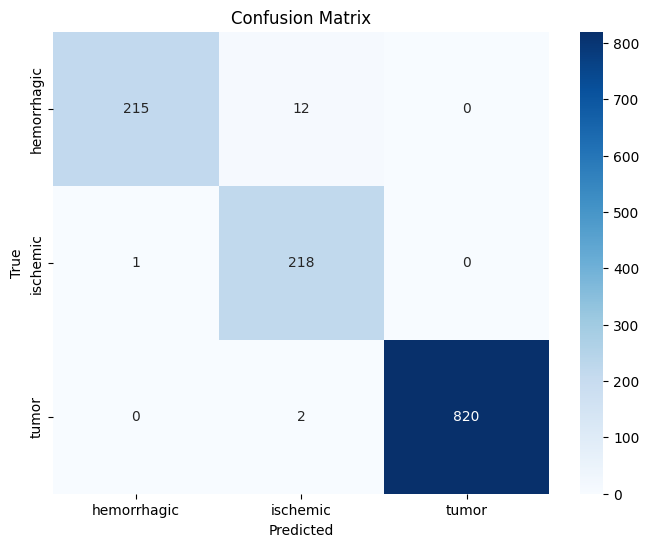

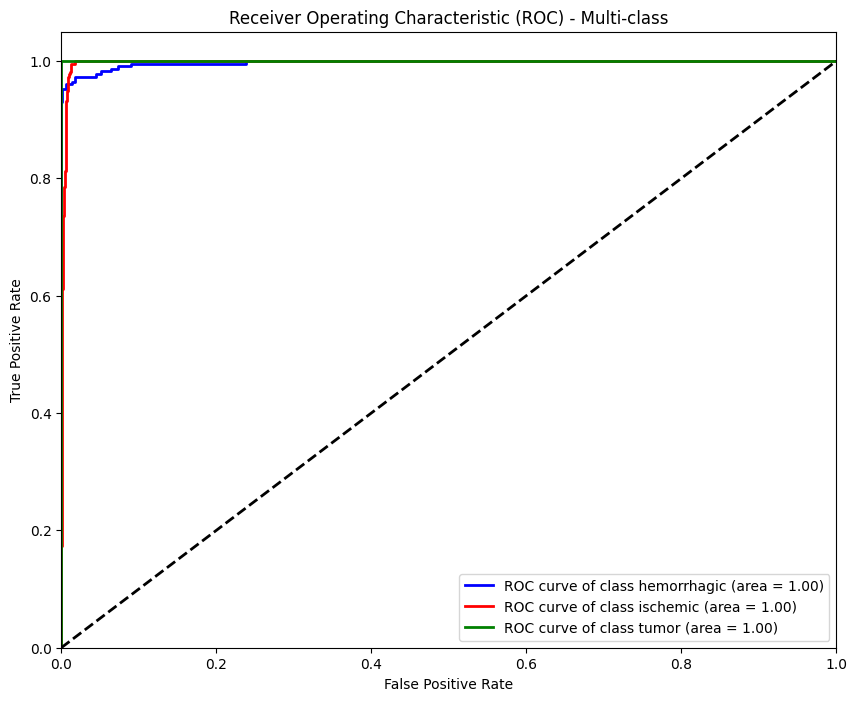

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 1. Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # 3. ROC Curves (One-vs-Rest)
    n_classes = len(classes)
    y_test = label_binarize(all_labels, classes=range(n_classes))
    y_score = np.array(all_probs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Load best model for evaluation
best_model = get_model(len(CLASSES))
best_model.load_state_dict(torch.load('../models/best_cnn.pth', map_location=DEVICE))
best_model = best_model.to(DEVICE)

print("Evaluating Best Model on Validation Set...")
evaluate_model(best_model, dataloaders['val'], CLASSES)